In [242]:
target = 6

### make sure preds and ground truths files match

In [243]:
predictions_path = f'./runs/detect/SIGGI_{target}/labels'
ground_truth_path = f'./../datasets/SIGGI/targets/{target}/labels/val'

In [244]:
import os

all_preds = [f for f in os.listdir(predictions_path) if f.endswith('.txt')]
all_gr_truths = [f for f in os.listdir(ground_truth_path) if f.endswith('.txt')]

print(len(set(all_preds)))
print(len(set(all_gr_truths)))

61
120


In [245]:
only_in_gr_truth = set(all_gr_truths) - set(all_preds)
len(only_in_gr_truth)

59

In [246]:
for missing_file in only_in_gr_truth:
    open(os.path.join(predictions_path, missing_file), 'w').close()

In [247]:
all_preds = [f for f in os.listdir(predictions_path) if f.endswith('.txt')]
len(set(all_preds))

120

In [248]:
if all_preds == all_gr_truths:
    print("Files match.")
else:
    print("Files do not match.")

Files match.


In [249]:
all_preds_paths = [os.path.join(predictions_path, f) for f in all_preds]
all_preds_paths.sort()
all_gr_truths_paths = [os.path.join(ground_truth_path, f) for f in all_gr_truths]
all_gr_truths_paths.sort()

### calculate IoU and save

In [250]:
def read_yolo_format(file_path):
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 5 or len(parts) == 6:  # class, x_center, y_center, width, height [+ confidence]
                if len(parts) == 5:
                    _, x_center, y_center, width, height = map(float, parts)
                    confidence = None
                elif len(parts) == 6:
                    _, x_center, y_center, width, height, confidence = map(float, parts)
                
                # Convert to [x1, y1, x2, y2] format
                x1 = x_center - width / 2
                y1 = y_center - height / 2
                x2 = x_center + width / 2
                y2 = y_center + height / 2
                
                boxes.append([x1, y1, x2, y2])
    return boxes

In [251]:
import torch
from torchvision.ops import box_iou

iou_list = []

for pred_file, gr_truth_file in zip(all_preds_paths, all_gr_truths_paths):
    predictions = read_yolo_format(pred_file)
    ground_truths = read_yolo_format(gr_truth_file)
    
    if predictions:
        predictions_tensor = torch.tensor(predictions)
    else:
        predictions_tensor = torch.tensor([[0.0, 0.0, 0.0, 0.0]])   # Handle empty predictions case

    if ground_truths:
        ground_truth_tensor = torch.tensor(ground_truths)   
    else:
        ground_truth_tensor = torch.tensor([[0.0, 0.0, 0.0, 0.0]])   # Handle empty ground truths case
        
    # for debugging
    predictions_list = predictions_tensor.tolist()
    ground_truth_list = ground_truth_tensor.tolist()

    for prediction in predictions_tensor:
        prediction = prediction.unsqueeze(0)
        iou = box_iou(prediction, ground_truth_tensor)
        iou_list.extend(iou.numpy().flatten().tolist())
        if iou.numpy().flatten().tolist()[0] ==0.0:
            print(f'{os.path.basename(pred_file)} pred={prediction} and truth={ground_truth_tensor}')

IMG_20230722_104616.txt pred=tensor([[0.5250, 0.3531, 0.5756, 0.5654]]) and truth=tensor([[0., 0., 0., 0.]])
IMG_20230722_104707.txt pred=tensor([[0.5336, 0.3373, 0.5728, 0.5637]]) and truth=tensor([[0., 0., 0., 0.]])
IMG_20230722_132222.txt pred=tensor([[0., 0., 0., 0.]]) and truth=tensor([[0.5571, 0.3456, 0.6718, 0.7189]])
IMG_20230722_132747.txt pred=tensor([[0.3082, 0.4960, 0.3364, 0.5671]]) and truth=tensor([[0.4328, 0.4804, 0.5287, 0.7558]])


In [252]:
file_path = f'./SIGGI_IoU_data/SIGGI_{target}.txt'

with open(file_path, 'w') as file:
    for iou in iou_list:
        file.write(f"{iou}\n")

In [202]:
# test_path = f'./runs/detect/SIGGI_{target}/labels/IMG_20230722_104517.txt'
# test_path2 = f'./../datasets/SIGGI/targets/{target}/labels/val/IMG_20230722_104517.txt'

# test = read_yolo_format(test_path)
# test2 = read_yolo_format(test_path2)

# if predictions:
#     predictions_tensor = torch.tensor(predictions)
# else:
#     predictions_tensor = torch.tensor([[0.0, 0.0, 0.0, 0.0]])   # Handle empty predictions case

# if ground_truths:
#     ground_truth_tensor = torch.tensor(ground_truths)   
# else:
#     ground_truth_tensor = torch.tensor([[0.0, 0.0, 0.0, 0.0]])

In [203]:
# ground_truths

In [204]:
# predictions_tensor

### load all data and plot histograms

In [256]:
data_lists = []
for t in range(7):
    file_path = f'./SIGGI_IoU_data/SIGGI_{t}.txt'
    
    iou_list = []

    with open(file_path, 'r') as file:
        for line in file:
            iou_list.append(float(line.strip()))
            
    data_lists.append(iou_list)

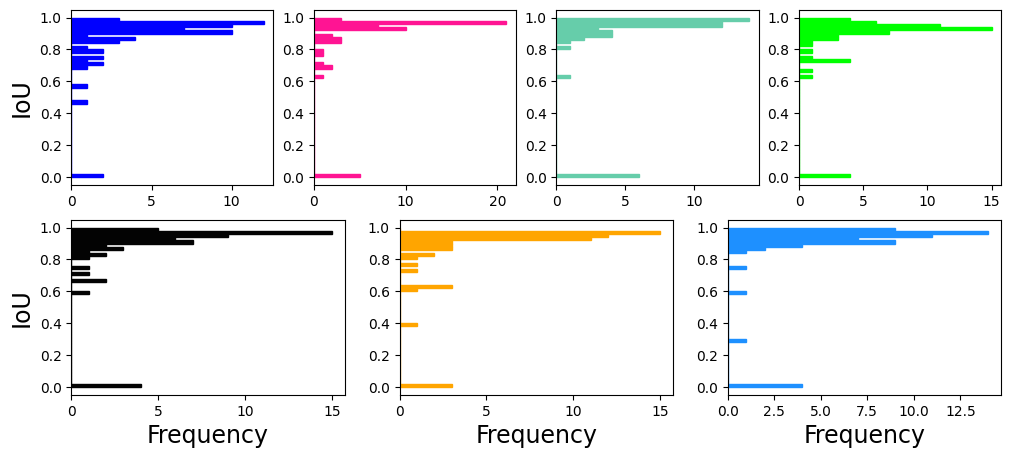

In [257]:
# data_lists = [iou_list,iou_list,iou_list,iou_list,iou_list,iou_list,iou_list]
titles = ['SIGGI_0', 'SIGGI_1', 'SIGGI_2', 'SIGGI_3', 'SIGGI_4', 'SIGGI_5', 'SIGGI_6']
colors = ['#0000FF', '#FF1493', '#66CDAA', '#00FF00', '#030303', '#FFA500', '#1E90FF']

num_histograms = len(data_lists)
# num_columns = 7
num_columns_first_row = 4
num_columns_second_row = 3

plt.figure(figsize=(12,5))
f=17

for i in range(num_columns_first_row):
    plt.subplot(2, num_columns_first_row, i+1)
    plt.hist(data_lists[i], bins=50, range=(0, 1), alpha=1, color=colors[i], edgecolor=colors[i], orientation='horizontal')
    # plt.title(titles[i], color=colors[i])
    # plt.xlabel('Frequency')
    if i==0:
        plt.ylabel('IoU', fontsize=f)
    
for i in range(num_columns_second_row):
    plt.subplot(2, num_columns_second_row, num_columns_first_row+i)
    plt.hist(data_lists[num_columns_first_row+i], bins=50, range=(0, 1), alpha=1, color=colors[num_columns_first_row+i], edgecolor=colors[num_columns_first_row+i], orientation='horizontal')
    # plt.title(titles[num_columns_first_row+i], color=colors[num_columns_first_row+i])
    plt.xlabel('Frequency', fontsize=f)
    if i==0:
        plt.ylabel('IoU', fontsize=f)

plt.show()